<h1>UCCD3074: Deep Learning for Data Science Group Assignment</h1>
<h2>June Trimester 2025</h2>

<h3>Title: Deep Learning-Based Classification of Skin Diseases and Cancer</h3>
<h3>Application-Based</h3>

<h3>Group 5:</h3>
<ul>
    <li>Loh Chia Heung (Leader) 2301684</li>
    <li>Tan Yi Xin 2101990</li>
    <li>Bester Loo Man Ting 2207066 </li>
    <li>Cornelius Wong Qin Jun 2104603 </li>
</ul>


<h3>Model Selection In This Project (4) :</h3>
<ul>
    <li>Tan Yi Xin: EfficientNet-B0</li>
    <li>Bester Loo Man Ting: DenseNet-121</li>
    <li>Loh Chia Heung: Swin Transformer</li>
    <li>Cornelius Wong Qin Jun: Inception V3</li>
</ul>


<h3> There are 7 Skin Lesion Classes: </h3>
<ul>
    <li> 1. akiec - Actinic keratoses and intraepithelial carcinoma </li>
    <li> 2. bcc - Basal cell carcinoma </li>
    <li> 3. bkl - Benign keratosis-like lesions</li>
    <li> 4. df - Dermatofibroma</li>
    <li> 5. mel - Melanoma</li>
    <li> 6. nv - Melanocytic nevi</li>
    <li> 7. vasc - Vascular lesions</li>
</ul>

<h3> Kaggle Dataset Link:</h3>
<a href="https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000">https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000</a>

### Codes Reuse
Prior to Modelling phase, some codes are reused referring to the following notebook(s)
> https://www.kaggle.com/code/lizk75/skin-cancer-resnet-balanced-98-acc (Data Proproceesing)

# 1. Setup and Imports

This section imports all necessary libraries and sets up the global configuration for the experiments, including model parameters, learning settings, and the device (GPU or CPU) to be used for training.

In [1]:
#################################
# Coded By: All Members
#################################

# Standard library
import os
import random
from glob import glob

# Data & computation
import numpy as np
import pandas as pd
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Preprocessing
from torchvision.transforms import v2
# Showing image
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as T

#for use this import for inceptionv3 using amp while training
from torch.cuda.amp import autocast, GradScaler

# Use kagglehub to download the dataset
import kagglehub

In [2]:
#################################
# Coded By: All Members
#################################

# --- CONFIGURATION ---
# Data and Paths
SEED = 42

# Model Hyperparameters
NUM_CLASSES = 7
IMG_SIZE = 224
FEATURE_EXTRACT = False  # False for fine-tuning, True for feature extraction
USE_PRETRAINED = True

# Training Hyperparameters
NUM_EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-4

# System Configuration
NUM_WORKERS = 4
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda:0


# 2. Data Loading and Initial Exploration

Here, we download the HAM10000 dataset directly from KaggleHub. We then load the metadata CSV file into a pandas DataFrame and perform an initial inspection to understand its structure and contents.

In [3]:
#################################
# Coded By: All Members
#################################

print("Downloading dataset from KaggleHub...")
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print(f"Dataset downloaded to: {path}")

Dataset downloaded to: /kaggle/input/skin-cancer-mnist-ham10000


In [4]:
#################################
# Coded By: All Members
#################################

dataset_path = "/kaggle/input/skin-cancer-mnist-ham10000"
metadata = pd.read_csv(os.path.join(dataset_path, "HAM10000_metadata.csv"))
num_examples = len(metadata)
print(f"Dataset loaded: {num_examples} samples")
metadata.head()

Dataset loaded: 10015 samples


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
#################################
# Coded By: All Members
#################################

metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


### Null in Age
*Decision to drop/fill*

In [6]:
#################################
# Coded By: All Members
#################################

metadata['age'] = metadata['age'].fillna(metadata['age'].median())

In [7]:
#################################
# Coded By: All Members
#################################

metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           10015 non-null  float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


# 3. Exploratory Data Analysis (EDA)
Show data balance / imbalance, distribution  etc.

In [8]:
#################################
# Adapted from https://www.kaggle.com/code/lizk75/skin-cancer-resnet-balanced-98-acc
#################################

# Create path mapping from both image folders
image_path = {}
for part in ['HAM10000_images_part_1', 'HAM10000_images_part_2']:
    folder_path = os.path.join(dataset_path, part)
    part_images = {os.path.splitext(os.path.basename(x))[0]: x
                   for x in glob(os.path.join(folder_path, '*.jpg'))}
    image_path.update(part_images)

print(f"Found {len(image_path)} images")

Found 10015 images


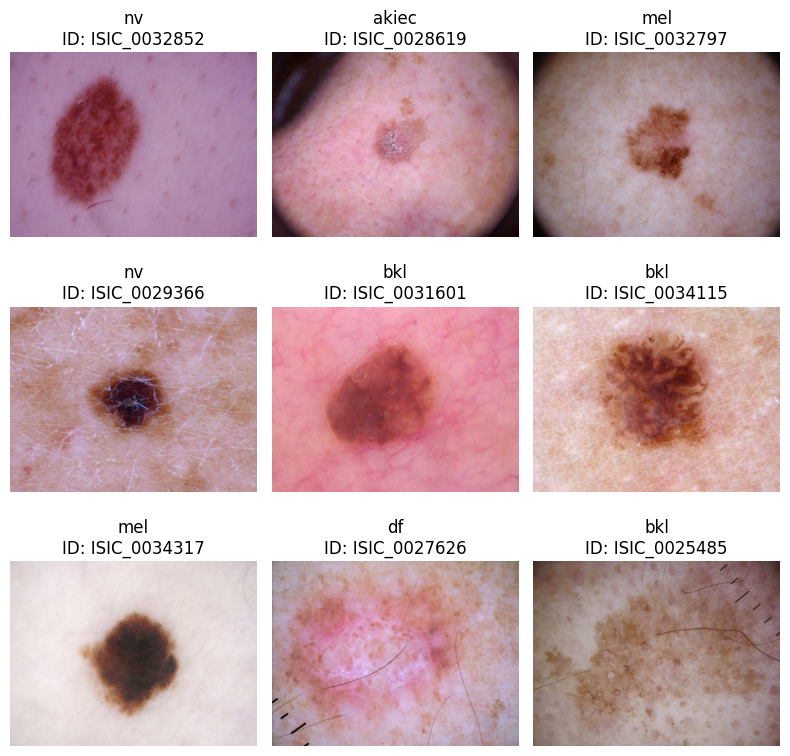

In [9]:
#################################
# Adapted from https://www.kaggle.com/code/lizk75/skin-cancer-resnet-balanced-98-acc
#################################

# Get 9 random image IDs
random_ids = random.sample(list(image_path.keys()), 9)

plt.figure(figsize=(8, 8))
for i, img_id in enumerate(random_ids):
   img_path = image_path[img_id]
   img = Image.open(img_path) 
   
   # Find the label for this image ID
   row = metadata[metadata['image_id'] == img_id]
   if not row.empty:
       label = row['dx'].iloc[0]
   else:
       label = 'Unknown'
   
   plt.subplot(3, 3, i+1)
   plt.imshow(img)
   plt.title(f'{label}\nID: {img_id}')
   plt.axis('off')

plt.tight_layout()
plt.show()

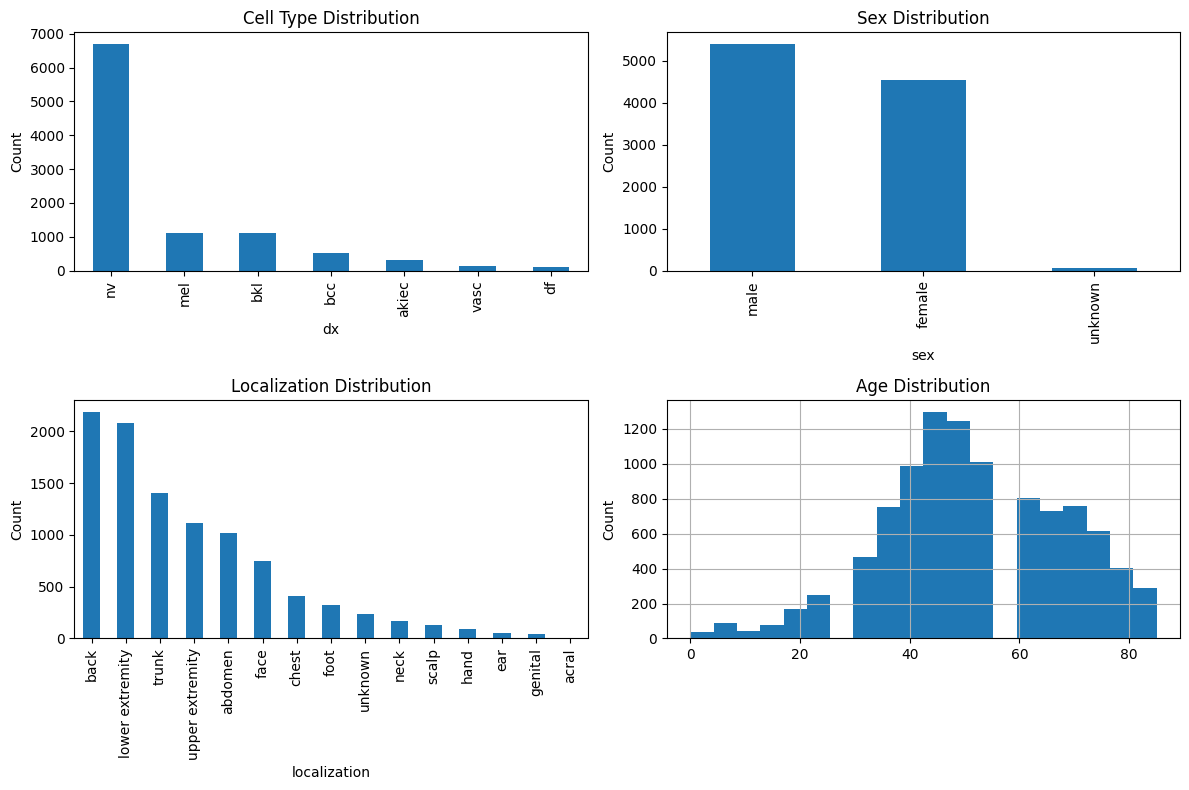

In [10]:
#################################
# Adapted from https://www.kaggle.com/code/lizk75/skin-cancer-resnet-balanced-98-acc
#################################

# Simple data distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Cell type distribution
metadata['dx'].value_counts().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Cell Type Distribution')
axes[0,0].set_ylabel('Count')

# Sex distribution  
metadata['sex'].value_counts().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Sex Distribution')
axes[0,1].set_ylabel('Count')

# Localization distribution
metadata['localization'].value_counts().plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Localization Distribution')
axes[1,0].set_ylabel('Count')

# Age distribution (simple histogram)
metadata['age'].hist(bins=20, ax=axes[1,1])
axes[1,1].set_title('Age Distribution')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# 4. Data Preprocessing Pipeline

This section contains all the functions required to process the metadata and prepare it for the model. The pipeline includes:
Label Encoding: Mapping lesion type codes (e.g., 'bkl', 'nv') to integer labels.
Image Path Resolution: Connecting each metadata entry to its corresponding image file path.
Data Splitting: Performing a stratified split to create training, validation, and test sets, ensuring the class distribution is maintained across splits.

## Label Mapping + Human-readable Name

In [11]:
#################################
# Coded By: Loh Chia Heung 
#################################

def prepare_labels(metadata):
    """
    Map short lesion codes (dx) to integer labels and keep full names for display.
    Returns:
        metadata (pd.DataFrame) with a new 'label' column
        label_names (list[str]) in index order
        full_label_names (dict[str->str]) for human readability
    """
    label_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
    full_label_names = {
        'akiec': 'Actinic keratoses and intraepithelial carcinoma',
        'bcc':   'Basal cell carcinoma',
        'bkl':   'Benign keratosis-like lesions',
        'df':    'Dermatofibroma',
        'mel':   'Melanoma',
        'nv':    'Melanocytic nevi',
        'vasc':  'Vascular lesions'
    }
    metadata = metadata.copy()
    metadata['label'] = metadata['dx'].map(lambda x: label_names.index(x))
    
    print("Imbalanced dataset distribution (by index):")
    print(metadata['label'].value_counts().sort_index())
    print("\nLabel mapping (index → code → full name):")
    for i, short in enumerate(label_names):
        print(f"  {i}: {short:<5} → {full_label_names[short]}")
    return metadata, label_names, full_label_names

## Resolve Image Paths

In [12]:
#################################
# Coded By: Loh Chia Heung 
#################################

def attach_image_paths(metadata, dataset_path):
    """
    Adds a 'path' column to metadata by resolving image_id to file paths.
    """
    image_path = {os.path.splitext(os.path.basename(x))[0]: x
                  for x in glob(os.path.join(dataset_path, '*', '*.jpg'))}
    metadata = metadata.copy()
    metadata['path'] = metadata['image_id'].map(image_path.get)
    missing = metadata['path'].isna().sum()
    if missing:
        print(f"{missing} images could not be resolved to a file path.")
        metadata = metadata.dropna(subset=['path']).reset_index(drop=True)
    return metadata

## Data Spliting

In [13]:
#################################
# Coded By: Loh Chia Heung & Adapt and make changes from https://www.kaggle.com/code/lizk75/skin-cancer-resnet-balanced-98-acc
#################################

def split_metadata(metadata, seed=42):
    """
    Stratified split into train/val/test as 60/20/20 of the original metadata.
    """
    train_df, test_df = train_test_split(
        metadata, test_size=0.2, random_state=seed, stratify=metadata['label']
    )
    train_df, val_df = train_test_split(
        train_df, test_size=0.25, random_state=seed, stratify=train_df['label']
    )
    print(f"\nSplits → Train: {len(train_df)}  Val: {len(val_df)}  Test: {len(test_df)}")
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

# 5. PyTorch Dataset and DataLoaders

This section defines the image transformations and the data loading mechanism.

## Image Transformation

Define separate augmentation pipelines for training (with random flips, rotations, etc.) and validation/testing (simple resizing and normalization).

In [14]:
#################################
# Coded By: Loh Chia Heung & Adapt and make changes from https://www.kaggle.com/code/lizk75/skin-cancer-resnet-balanced-98-acc
#################################

def build_transforms(img_size=224):
    """
    Returns torchvision transforms for train and validation/test.
    """
    norm_mean = [0.485, 0.456, 0.406]
    norm_std  = [0.229, 0.224, 0.225]
    train_tf = T.Compose([
        T.Resize((img_size, img_size)),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomRotation(20),
        T.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
        T.ToTensor(),
        T.Normalize(norm_mean, norm_std),
    ])
    val_tf = T.Compose([
        T.Resize((img_size, img_size)),
        T.ToTensor(),
        T.Normalize(norm_mean, norm_std),
    ])
    return train_tf, val_tf

# Custom Dataset

A SkinDataset class is created to load images and labels on-the-fly.

In [15]:
#################################
# Coded By: Loh Chia Heung & Adapt and make changes from https://www.kaggle.com/code/lizk75/skin-cancer-resnet-balanced-98-acc
#################################

class SkinDataset(Dataset):
    """
    Minimal dataset: expects columns 'path' (string) and 'label' (int).
    """
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_paths = self.df['path'].values
        self.labels = self.df['label'].values.astype(int)
        self.transform = transform

    def __len__(self): 
        return len(self.df)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        y = int(self.labels[idx])
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, y

# Data Loaders

The make_loaders function creates DataLoader instances for each data split. Crucially, it uses a WeightedRandomSampler for the training loader to address the severe class imbalance in the dataset, ensuring the model sees a more balanced distribution of classes during training.

In [16]:
#################################
# Coded By: Loh Chia Heung & Adapt and make changes from https://www.kaggle.com/code/lizk75/skin-cancer-resnet-balanced-98-acc
#################################

def make_loaders(train_df, val_df, test_df, train_tf, val_tf,
                 batch_train=32, batch_eval=64, num_workers=4, pin_memory=True, seed=42):
    """
    Returns train/val/test dataloaders using WeightedRandomSampler for TRAIN only.
    """
    train_ds = SkinDataset(train_df, transform=train_tf)
    val_ds   = SkinDataset(val_df,   transform=val_tf)
    test_ds  = SkinDataset(test_df,  transform=val_tf)

    # Build sampler from TRAIN labels
    num_classes = int(max(train_df['label'])) + 1
    train_labels = train_df['label'].to_numpy().astype(int)
    class_counts = np.bincount(train_labels, minlength=num_classes)
    class_weights = 1.0 / np.maximum(class_counts, 1)    # inverse frequency
    sample_weights = class_weights[train_labels]

    train_sampler = WeightedRandomSampler(
        weights=torch.as_tensor(sample_weights, dtype=torch.double),
        num_samples=len(sample_weights),   # one epoch ~ len(train_df)
        replacement=True
    )
    print("\nTrain class counts:", class_counts.tolist())

    g = torch.Generator().manual_seed(seed)

    train_loader = DataLoader(
        train_ds, batch_size=batch_train,
        sampler=train_sampler, shuffle=False,  # sampler and shuffle are mutually exclusive
        num_workers=num_workers, pin_memory=pin_memory, generator=g
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_eval,
        shuffle=False, num_workers=num_workers, pin_memory=pin_memory
    )
    test_loader = DataLoader(
        test_ds, batch_size=batch_eval,
        shuffle=False, num_workers=num_workers, pin_memory=pin_memory
    )
    return train_loader, val_loader, test_loader

### Quick Checks

In [17]:
#################################
# Generated from ChatGPT
#################################

from collections import Counter

def peek_balance(loader, n_batches=5, label_names=None):
    it = iter(loader); cnt = Counter(); total = 0
    for _ in range(n_batches):
        try:
            _, y = next(it)
        except StopIteration:
            break
        ys = y.detach().cpu().tolist()
        cnt.update(ys); total += len(ys)
    print(f"\nPeeked {total} samples over {n_batches} batch(es):")
    for c in sorted(cnt.keys()):
        name = label_names[c] if label_names else c
        print(f"  class {c} ({name}): {cnt[c]}")

def epoch_balance(loader, label_names=None):
    cnt = Counter(); total = 0
    for _, y in loader:
        ys = y.detach().cpu().tolist()
        cnt.update(ys); total += len(ys)
    print(f"\nEpoch total: {total} samples")
    for c in range((len(label_names) if label_names else (max(cnt.keys())+1))):
        name = label_names[c] if label_names else c
        print(f"  class {c} ({name}): {cnt[c]}")
    return cnt

In [18]:
#################################
# Generated from ChatGPT
#################################

# === DRIVER ===
metadata2, label_names, full_label_names = prepare_labels(metadata)
metadata2 = attach_image_paths(metadata2, dataset_path)
train_df, val_df, test_df = split_metadata(metadata2, seed=42)
train_tf, val_tf = build_transforms(img_size=224)
train_loader, val_loader, test_loader = make_loaders(
    train_df, val_df, test_df, train_tf, val_tf,
    batch_train=32, batch_eval=64, num_workers=4, pin_memory=True, seed=42
)

# Sanity checks
peek_balance(train_loader, n_batches=5, label_names=label_names)
epoch_balance(train_loader, label_names=label_names)

# Loss: keep it UNWEIGHTED with sampler
criterion = torch.nn.CrossEntropyLoss()

Imbalanced dataset distribution (by index):
label
0     327
1     514
2    1099
3     115
4    1113
5    6705
6     142
Name: count, dtype: int64

Label mapping (index → code → full name):
  0: akiec → Actinic keratoses and intraepithelial carcinoma
  1: bcc   → Basal cell carcinoma
  2: bkl   → Benign keratosis-like lesions
  3: df    → Dermatofibroma
  4: mel   → Melanoma
  5: nv    → Melanocytic nevi
  6: vasc  → Vascular lesions

Splits → Train: 6009  Val: 2003  Test: 2003

Train class counts: [197, 308, 659, 69, 668, 4023, 85]

Peeked 160 samples over 5 batch(es):
  class 0 (akiec): 24
  class 1 (bcc): 18
  class 2 (bkl): 23
  class 3 (df): 19
  class 4 (mel): 27
  class 5 (nv): 23
  class 6 (vasc): 26

Epoch total: 6009 samples
  class 0 (akiec): 852
  class 1 (bcc): 846
  class 2 (bkl): 862
  class 3 (df): 852
  class 4 (mel): 880
  class 5 (nv): 865
  class 6 (vasc): 852


# 6. Modeling and Training Utilities

This section contains helper classes and functions for building, training, and evaluating models.

## AverageMeter

A utility for tracking running averages of metrics like loss and accuracy.

In [19]:
#################################
# Coded By: All members
#################################

class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0; 
        self.avg = 0; 
        self.sum = 0; 
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val; 
        self.sum += val * n; 
        self.count += n; 
        self.avg = self.sum / self.count

## Early Stopping

A callback to stop training if the validation loss does not improve for a specified number of epochs, preventing overfitting and saving the best model.

In [20]:
#################################
# Coded By: Tan Yi Xin
#################################

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth', trace_func=print):
        self.patience = patience; 
        self.verbose = verbose; 
        self.counter = 0; self.best_score = None
        self.early_stop = False; 
        self.val_loss_min = np.Inf; 
        self.delta = delta
        self.path = path; self.trace_func = trace_func
        
    def __call__(self, val_loss, model):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score; 
            self.save_checkpoint(val_loss, model)
            
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: self.early_stop = True
                
        else:
            self.best_score = score; self.save_checkpoint(val_loss, model); self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        
        torch.save(model.state_dict(), self.path); self.val_loss_min = val_loss

## Model Initialization

A factory function to create different model architectures (e.g., EfficientNet, DenseNet) with a custom final classification layer.

In [21]:
#################################
# Coded By: All members
#################################

def set_parameter_requires_grad(model, feature_extracting, unfreeze_strategy=None):
    """
    Freezes model parameters if feature_extracting=True.
    If InceptionV3, allows flexible unfreezing strategy:
      - 'last'  : Unfreeze Mixed_7b & Mixed_7c + fc
      - 'last3' : Unfreeze Mixed_6e, Mixed_7a, Mixed_7b, Mixed_7c + fc
      - 'full'  : Unfreeze entire network
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

        ############################ 
        # Coded by Cornelius Wong Qin Jun
        ############################

        if isinstance(model, models.Inception3) and unfreeze_strategy is not None:
            if unfreeze_strategy == "last":
                print("[INFO] Unfreezing Inception blocks: Mixed_7b & Mixed_7c + fc")
                for name, param in model.named_parameters():
                    if any(k in name for k in ["Mixed_7b", "Mixed_7c", "fc"]):
                        param.requires_grad = True

            elif unfreeze_strategy == "last3":
                print("[INFO] Unfreezing Inception blocks: Mixed_6e, Mixed_7a, Mixed_7b, Mixed_7c + fc")
                for name, param in model.named_parameters():
                    if any(k in name for k in ["Mixed_6e", "Mixed_7a", "Mixed_7b", "Mixed_7c", "fc"]):
                        param.requires_grad = True

            elif unfreeze_strategy == "full":
                print("[INFO] Full fine-tuning: All InceptionV3 layers are trainable")
                for param in model.parameters():
                    param.requires_grad = True


In [22]:
#################################
# Coded By: All members
#################################

def initialize_model(model_name, num_classes, feature_extract=True, use_pretrained=True, unfreeze_strategy=None):
    """
    Initializes a model with the modern `weights` API.
    Supports flexible unfreezing for InceptionV3.
    """
    weights = 'IMAGENET1K_V1' if use_pretrained else None
    model_ft = None
    input_size = 0
    
    if model_name == "efficientnet_b0":
        model_ft = models.efficientnet_b0(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[-1].in_features
        model_ft.classifier[-1] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "swin_t":
        model_ft = models.swin_t(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.head.in_features
        model_ft.head = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "densenet121":
        model_ft = models.densenet121(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    ############################ 
    # Adapted / Generated from https://www.kaggle.com/code/ornedehj/ham-preprocessing-acc-88
    ############################
    elif model_name == "inception_v3":
        model_ft = models.inception_v3(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract, unfreeze_strategy=unfreeze_strategy)

        # Aux classifier
        num_ftrs_aux = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs_aux, num_classes)

        # Final fc
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 299

    else:
        raise NotImplementedError(f"Model '{model_name}' is not supported yet.")

    return model_ft, input_size


In [23]:
#################################
# Coded By: Loh Chia Heung
#################################

def show_network_structure(model_name, num_classes=2, feature_extract=True, use_pretrained=True):
    """
    Build the model and print its network structure
    """
    model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained)

    print("="*60)
    print(f"Network structure for {model_name.upper()} (input size {input_size}x{input_size})")
    print("="*60)
    print(model_ft)
    print("\n")

    return model_ft


In [24]:
#################################
# Coded By: Loh Chia Heung
#################################

# Model 1 - EfficientNet-B0
model_eff, input_size = initialize_model("efficientnet_b0", num_classes=7)
print(model_eff)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 119MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [25]:
#################################
# Coded By: Loh Chia Heung
#################################

# Model 2 - DenseNet - 121
model_dense, input_size = initialize_model("densenet121", num_classes=7)
print(model_dense)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 144MB/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [26]:
#################################
# Coded By: Loh Chia Heung
#################################

# Model 3 - Swim Transformer
model_swin, input_size = initialize_model("swin_t", num_classes=7)
print(model_swin)


Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 170MB/s] 


SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(
       

In [27]:
#################################
# Coded By: Loh Chia Heung
#################################

# Model 4 - InceptionV3
model_inc, input_size = initialize_model("inception_v3", num_classes=7)
print(model_inc)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 177MB/s]


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

## train_one_epoch / validate_one_epoch

Core functions that perform a single pass of training or validation over the dataset.

In [28]:
#################################
# Coded By: All Members
#################################

def train_one_epoch(model, loader, criterion, optimizer, device, epoch, scaler=None):
    model.train()
    losses, accuracies = AverageMeter(), AverageMeter()

    for i, (inputs, labels) in enumerate(loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        if scaler is not None:

            ############################ 
            # Coded by Cornelius Wong Qin Jun for the amp apply
            ############################
            # handle inception 3 because heavy
            with torch.amp.autocast("cuda"): 
            
                outputs = model(inputs)

                if isinstance(outputs, tuple):  # inception_v3 case
                    main_outputs, aux_outputs = outputs
                    loss1 = criterion(main_outputs, labels)
                    loss2 = criterion(aux_outputs, labels)
                    loss = loss1 + 0.4 * loss2
                    final_outputs = main_outputs
                else:
                    loss = criterion(outputs, labels)
                    final_outputs = outputs

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)

            if isinstance(outputs, tuple):  # inception_v3 case
                main_outputs, aux_outputs = outputs
                loss1 = criterion(main_outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + 0.4 * loss2
                final_outputs = main_outputs
            else:
                loss = criterion(outputs, labels)
                final_outputs = outputs

            loss.backward()
            optimizer.step()

        preds = final_outputs.argmax(dim=1)
        losses.update(loss.item(), inputs.size(0))
        accuracies.update((preds == labels).sum().item() / inputs.size(0), inputs.size(0))

    return losses.avg, accuracies.avg

In [29]:
#################################
# Generated from ChatGPT
#################################

def validate_one_epoch(model, loader, criterion, device):
    model.eval(); losses, accuracies = AverageMeter(), AverageMeter()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs); loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1)
            losses.update(loss.item(), inputs.size(0))
            accuracies.update((preds == labels).sum().item() / inputs.size(0), inputs.size(0))
    return losses.avg, accuracies.avg

## Generate Evaluation Report Function

A function to compute and display a detailed classification report and a confusion matrix for model evaluation

In [30]:
#################################
# Generated from ChatGPT
#################################

def generate_evaluation_report(model, loader, device, label_names):
    """
    Generates and displays a full evaluation report including a classification
    report and a confusion matrix.
    """
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    # No need to track gradients for evaluation
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # Get the predicted class indices
            preds = outputs.argmax(dim=1)
            
            # Append batch predictions and labels to lists
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # --- Classification Report ---
    print("=" * 50)
    print("           Classification Report")
    print("=" * 50)
    # The report shows precision, recall, and F1-score for each class
    print(classification_report(all_labels, all_preds, target_names=label_names, digits=4))
    
    # --- Confusion Matrix ---
    print("=" * 50)
    print("             Confusion Matrix")
    print("=" * 50)
    cm = confusion_matrix(all_labels, all_preds)
    
    # Use a DataFrame for better labeling
    cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=.5)
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

# 7. Main Training and Evaluation Pipeline

This section brings everything together. The run_experiment function encapsulates the entire process for a given model:

## a. Run Training funtion (contains the epoch loop)

In [31]:
#################################
# Coded By: Tan Yi Xin
#################################

def run_training(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopper, num_epochs, device, use_amp=False):
    """
    Executes the main training loop for a given number of epochs.
    (This version is updated to handle the verbose=True deprecation warning.)
    """
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    scaler = torch.cuda.amp.GradScaler() if use_amp else None

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}\n" + "-" * 15)
        
        # Get the learning rate before the training epoch
        # optimizer.param_groups is a list of parameter groups. Usually only have one.
        old_lr = optimizer.param_groups[0]['lr']

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, scaler)
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch Summary -> Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        
        # Step the scheduler
        scheduler.step(val_loss)
        
        # Get the new learning rate after the scheduler step
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr < old_lr:
            print(f"Learning rate reduced from {old_lr:.6f} to {new_lr:.6f}")
        # --- END OF NEW CODE ---
        
        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break
            
    time_elapsed = time.time() - start_time
    print(f"\n--- Training Complete ---")
    print(f"Total time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Val Loss: {early_stopper.val_loss_min:.4f} (Model saved to '{early_stopper.path}')")
    
    model.load_state_dict(torch.load(early_stopper.path))
    return model, history

## b. Run Experiment (function handles the entire lifecycle of a single model—from initialization to final evaluation—making our main script clean and scalable.)

In [32]:
#################################
# Coded By: Tan Yi Xin
#################################

def run_experiment(model_name, patience, img_size, train_loader, val_loader, test_loader, config):
    """
    Initializes, trains, and evaluates a single model, now with production model saving.
    """
    print("\n" + "#" * 60)
    print(f"### STARTING EXPERIMENT: {model_name.upper()} (Image Size: {img_size}x{img_size}) ###")
    print("#" * 60 + "\n")

    # 1. Initialize Model
    model, _ = initialize_model(
        model_name, config['num_classes'], config['feature_extract'], config['use_pretrained']
    )
    model = model.to(config['device'])
    print(f"Model '{model_name}' initialized on {config['device']}.")

    # 2. Set up training components
    optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss().to(config['device'])
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)
    early_stopper = EarlyStopping(patience=patience, verbose=True, path=f'{model_name}_best_model.pth')
    
    # 3. Run Training
    best_model, history = run_training(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        early_stopper, config['num_epochs'], config['device']
    )

    # 4. Evaluate on the Test Set
    print(f"\n--- Evaluating Final {model_name.upper()} Model on the Unseen Test Set ---")
    generate_evaluation_report(best_model, test_loader, config['device'], config['label_names'])

    # --- 5. SAVE FOR PRODUCTION (WEB DEPLOYMENT) ---
    print(f"\n--- Saving Production Model for {model_name.upper()} ---")
    try:
        # Create a dummy input tensor with the correct size and device
        dummy_input = torch.randn(1, 3, img_size, img_size, device=config['device'])
        
        # Trace the model to create a TorchScript module
        traced_script_module = torch.jit.trace(best_model, dummy_input)
        
        # Save the traced model
        prod_model_path = f'{model_name}_production_model.pt'
        traced_script_module.save(prod_model_path)
        
        print(f"✅ Production-ready model saved to: {prod_model_path}")
        print("   This is the file to use in your web application.")

    except Exception as e:
        print(f"Could not save production model for {model_name}. Error: {e}")

    return best_model, history

# 8. Execution: Running All Experiments

This final section defines the configurations for each model you want to train and then loops through them, executing the full training and evaluation pipeline for each one. To add more models, simply add a new dictionary to the experiments list.

In [33]:
#################################
# Coded By: All Members
#################################

# --- Define Shared Configuration ---
# These parameters are common across all experiments
base_config = {
    'num_classes': NUM_CLASSES, 'feature_extract': FEATURE_EXTRACT,
    'use_pretrained': USE_PRETRAINED, 'device': DEVICE, 'lr': LEARNING_RATE,
    'num_epochs': NUM_EPOCHS, 'label_names': label_names
}

In [34]:
#################################
# Coded By: All Members
#################################

data_loaders = {}
required_sizes = {224, 299} # Set of unique image sizes needed

for size in required_sizes:
    print(f"\nCreating DataLoaders for image size {size}x{size}...")
    train_tf, val_tf = build_transforms(img_size=size)
    train_loader, val_loader, test_loader = make_loaders(
        train_df, val_df, test_df, train_tf, val_tf, BATCH_SIZE, NUM_WORKERS, SEED
    )
    data_loaders[size] = (train_loader, val_loader, test_loader)


Creating DataLoaders for image size 224x224...

Train class counts: [197, 308, 659, 69, 668, 4023, 85]

Creating DataLoaders for image size 299x299...

Train class counts: [197, 308, 659, 69, 668, 4023, 85]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 42 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [35]:
#################################
# Coded By: All Members
#################################

# --- 3. Define Model-Specific Experiment Configurations ---
experiments = [
    {
        'name': 'Tan Yi Xin',
        'model_name': 'efficientnet_b0',
        'patience': 10,
        'img_size': 224
    },
    {
        'name': 'Bester Loo Man Ting',
        'model_name': 'densenet121',
        'patience': 10,
        'img_size': 224
    },
    # {
    #      For the Inception Model, it move to the bottom part 
    #     'name': 'Cornelius Wong Qin Jun',
    #     'model_name': 'inception_v3',
    #     'patience': 10,
    #     'img_size': 299  # Special image size
    # },
    {
        'name': 'Loh Chia Heung ',
        'model_name': 'swin_t',
        'patience': 10,
        'img_size': 224
    }
]



--- Preparing experiment for Tan Yi Xin (efficientnet_b0) ---

############################################################
### STARTING EXPERIMENT: EFFICIENTNET_B0 (Image Size: 224x224) ###
############################################################

Model 'efficientnet_b0' initialized on cuda:0.

Epoch 1/100
---------------
Epoch Summary -> Train Loss: 1.2197, Acc: 0.5705 | Val Loss: 0.8256, Acc: 0.6850
Validation loss decreased (inf --> 0.825640). Saving model ...

Epoch 2/100
---------------
Epoch Summary -> Train Loss: 0.6408, Acc: 0.7685 | Val Loss: 0.6261, Acc: 0.7649
Validation loss decreased (0.825640 --> 0.626062). Saving model ...

Epoch 3/100
---------------
Epoch Summary -> Train Loss: 0.4714, Acc: 0.8321 | Val Loss: 0.6010, Acc: 0.7873
Validation loss decreased (0.626062 --> 0.601046). Saving model ...

Epoch 4/100
---------------
Epoch Summary -> Train Loss: 0.3959, Acc: 0.8570 | Val Loss: 0.6085, Acc: 0.7664
EarlyStopping counter: 1 out of 10

Epoch 5/100
------------

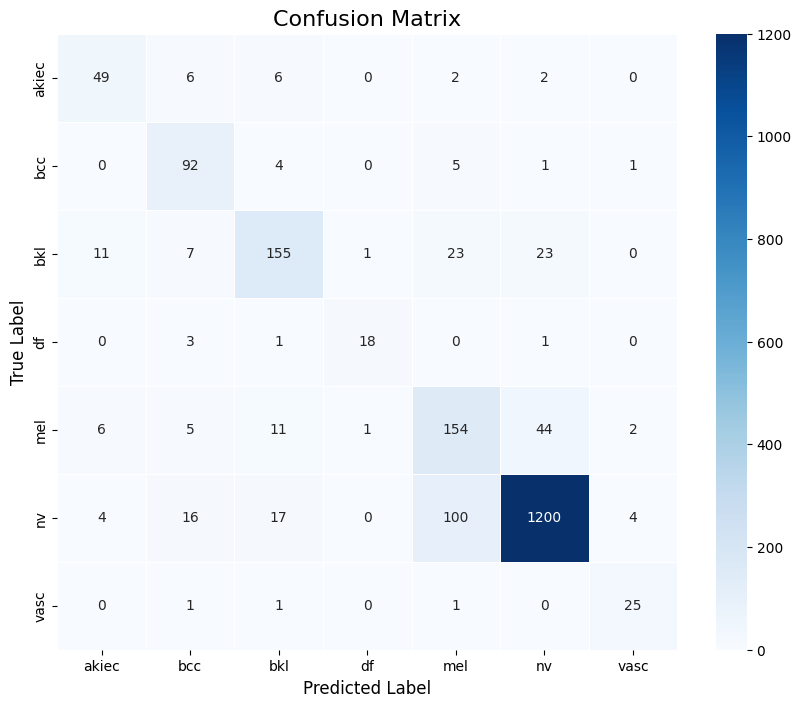


--- Saving Production Model for EFFICIENTNET_B0 ---
✅ Production-ready model saved to: efficientnet_b0_production_model.pt
   This is the file to use in your web application.

--- Preparing experiment for Bester Loo Man Ting (densenet121) ---

############################################################
### STARTING EXPERIMENT: DENSENET121 (Image Size: 224x224) ###
############################################################

Model 'densenet121' initialized on cuda:0.

Epoch 1/100
---------------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 42 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch Summary -> Train Loss: 0.9347, Acc: 0.6673 | Val Loss: 0.8111, Acc: 0.6805
Validation loss decreased (inf --> 0.811117). Saving model ...

Epoch 2/100
---------------
Epoch Summary -> Train Loss: 0.5217, Acc: 0.8106 | Val Loss: 0.6685, Acc: 0.7504
Validation loss decreased (0.811117 --> 0.668522). Saving model ...

Epoch 3/100
---------------
Epoch Summary -> Train Loss: 0.4220, Acc: 0.8501 | Val Loss: 0.5320, Acc: 0.7978
Validation loss decreased (0.668522 --> 0.531987). Saving model ...

Epoch 4/100
---------------
Epoch Summary -> Train Loss: 0.3465, Acc: 0.8740 | Val Loss: 0.5945, Acc: 0.7713
EarlyStopping counter: 1 out of 10

Epoch 5/100
---------------
Epoch Summary -> Train Loss: 0.2998, Acc: 0.8925 | Val Loss: 0.7349, Acc: 0.7079
EarlyStopping counter: 2 out of 10

Epoch 6/100
---------------
Epoch Summary -> Train Loss: 0.2588, Acc: 0.9105 | Val Loss: 0.6371, Acc: 0.7469
EarlyStopping counter: 3 out of 10

Epoch 7/100
---------------
Epoch Summary -> Train Loss: 0.2328,

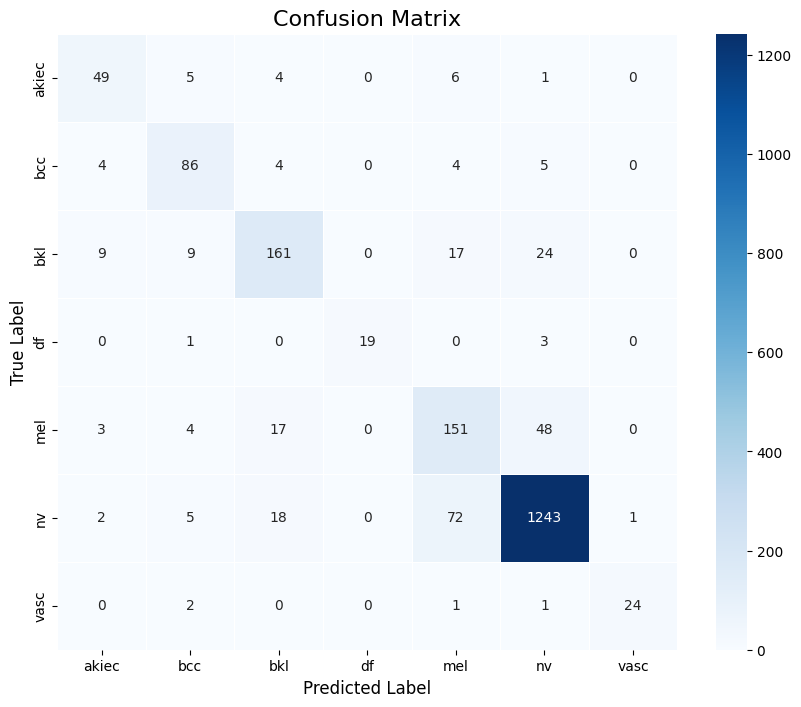


--- Saving Production Model for DENSENET121 ---
✅ Production-ready model saved to: densenet121_production_model.pt
   This is the file to use in your web application.

--- Preparing experiment for Loh Chia Heung  (swin_t) ---

############################################################
### STARTING EXPERIMENT: SWIN_T (Image Size: 224x224) ###
############################################################

Model 'swin_t' initialized on cuda:0.

Epoch 1/100
---------------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 42 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch Summary -> Train Loss: 1.0085, Acc: 0.6141 | Val Loss: 0.6610, Acc: 0.7664
Validation loss decreased (inf --> 0.660972). Saving model ...

Epoch 2/100
---------------
Epoch Summary -> Train Loss: 0.5643, Acc: 0.7936 | Val Loss: 0.6741, Acc: 0.7269
EarlyStopping counter: 1 out of 10

Epoch 3/100
---------------
Epoch Summary -> Train Loss: 0.4724, Acc: 0.8241 | Val Loss: 0.7789, Acc: 0.6930
EarlyStopping counter: 2 out of 10

Epoch 4/100
---------------
Epoch Summary -> Train Loss: 0.3831, Acc: 0.8556 | Val Loss: 0.4761, Acc: 0.8248
Validation loss decreased (0.660972 --> 0.476081). Saving model ...

Epoch 5/100
---------------
Epoch Summary -> Train Loss: 0.3193, Acc: 0.8842 | Val Loss: 0.4930, Acc: 0.8293
EarlyStopping counter: 1 out of 10

Epoch 6/100
---------------
Epoch Summary -> Train Loss: 0.2834, Acc: 0.8930 | Val Loss: 0.5366, Acc: 0.8183
EarlyStopping counter: 2 out of 10

Epoch 7/100
---------------
Epoch Summary -> Train Loss: 0.2614, Acc: 0.9028 | Val Loss: 0.6182, 

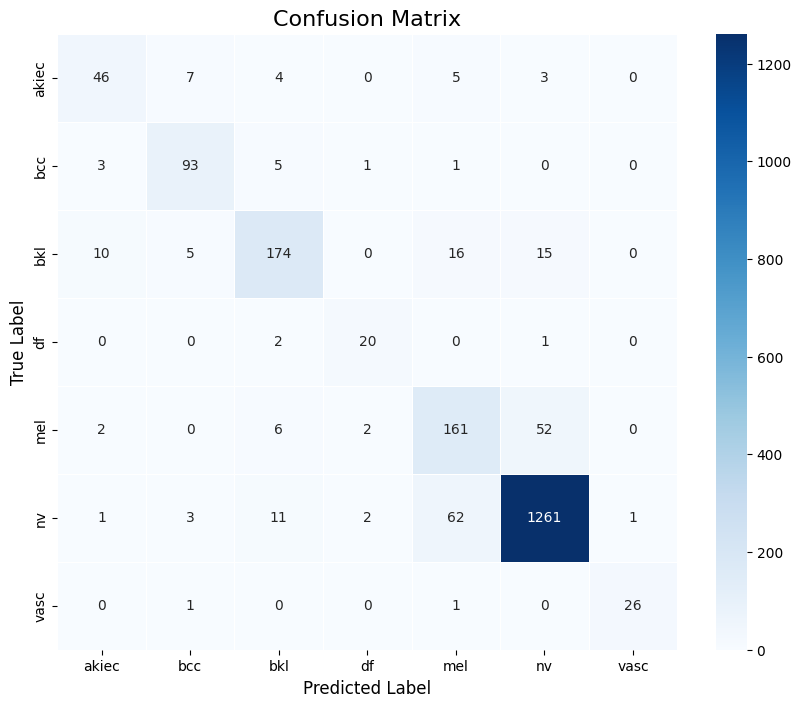


--- Saving Production Model for SWIN_T ---
✅ Production-ready model saved to: swin_t_production_model.pt
   This is the file to use in your web application.


All experiments completed.


In [36]:
#################################
# Coded By: All Members
#################################

# --- 4. Loop Through and Run All Experiments ---
results = {}
for experiment in experiments:
    model_name = experiment['model_name']
    img_size = experiment['img_size']
    
    # Select the correct DataLoaders based on the required image size
    train_loader, val_loader, test_loader = data_loaders[img_size]
    
    print(f"\n--- Preparing experiment for {experiment['name']} ({model_name}) ---")
    
    best_model, history = run_experiment(
        model_name=model_name,
        patience=experiment['patience'],
        img_size=img_size,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        config=base_config
    )
    results[model_name] = {'model': best_model, 'history': history}

print("\n\nAll experiments completed.")

## 4th Model -  Inception V3 running(Cornelius Wong Qin Jun):

In [37]:
#################################
# Coded By: Cornelius Wong Qin Jun
#################################

input_size=299
# geneerate 299 size of input
metadata2, label_names, full_label_names = prepare_labels(metadata)
metadata2 = attach_image_paths(metadata2, dataset_path)
train_df, val_df, test_df = split_metadata(metadata2, seed=42)
# change image size to suit inceptionv3 (299)
train_tf, val_tf = build_transforms(img_size=input_size)
train_loader, val_loader, test_loader = make_loaders(
    train_df, val_df, test_df, train_tf, val_tf,
    batch_train=16, batch_eval=32, num_workers=4, pin_memory=True, seed=42
) # batch train and batch_eval reduce  due prevent too heavy for inception_v3

Imbalanced dataset distribution (by index):
label
0     327
1     514
2    1099
3     115
4    1113
5    6705
6     142
Name: count, dtype: int64

Label mapping (index → code → full name):
  0: akiec → Actinic keratoses and intraepithelial carcinoma
  1: bcc   → Basal cell carcinoma
  2: bkl   → Benign keratosis-like lesions
  3: df    → Dermatofibroma
  4: mel   → Melanoma
  5: nv    → Melanocytic nevi
  6: vasc  → Vascular lesions

Splits → Train: 6009  Val: 2003  Test: 2003

Train class counts: [197, 308, 659, 69, 668, 4023, 85]


In [38]:
#################################
# Coded By: Cornelius Wong Qin Jun
#################################

Wandb_config_fine_tune_last_three =  {
    'MODEL_NAME': 'inception_v3',
    'NUM_CLASSES' : 7,
    'NUM_EPOCHS' :100,
    'BATCH_SIZE' : 16, 
    'LEARNING_RATE_cls' : 1e-3,
    'LEARNING_RATE_backbone' : 1e-4,
    'PATIENCE' : 10,
    'NUM_WORKERS': 2,
    'SEED' : 42,
    'FEATURE_EXTRACT': True,
    'USE_PRETRAINED': True,
    'use_amp': True,
    'unfreeze_strategy':"last3"
}

In [39]:
#################################
# Coded By: Cornelius Wong Qin Jun
#################################

MODEL_NAME = 'inception_v3'
NUM_CLASSES = 7
NUM_EPOCHS = 100
BATCH_SIZE = 16 # change from 32 -> 16 due to inception is heavy
LEARNING_RATE_CLS = 1e-3  #from 1e-3 for classifier
LEARNING_RATE_BACKBONE = 1e-4  #from 1e-4 for backbone inception block
PATIENCE = 10   
NUM_WORKERS = 2
SEED = 42
UNFREEZE_STRATEGY="last3"  # last 3 unfreeze

FEATURE_EXTRACT = True 
USE_PRETRAINED = True
use_amp=True

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Setting configuration for inception  v3

In [40]:
############################ 
# Coded by Cornelius Wong Qin Jun for the amp apply
############################

model, input_size = initialize_model(
    model_name=MODEL_NAME,
    num_classes=NUM_CLASSES,
    feature_extract=FEATURE_EXTRACT,
    use_pretrained=USE_PRETRAINED,
    unfreeze_strategy=UNFREEZE_STRATEGY
)

model = model.to(DEVICE)

# Split param groups
classifier_params = []
backbone_params = []

for name, param in model.named_parameters():
    if param.requires_grad:
        if "fc" in name:  # includes AuxLogits.fc and final fc
            classifier_params.append(param)
            print("Classifier param:", name)
        else:
            backbone_params.append(param)
            print("Backbone param:", name)

optimizer = optim.AdamW([
    {"params": backbone_params, "lr": LEARNING_RATE_BACKBONE},   # fine-tune with smaller LR
    {"params": classifier_params, "lr": LEARNING_RATE_CLS}  # head gets higher LR
], weight_decay=1e-4)



criterion = nn.CrossEntropyLoss().to(DEVICE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=7, verbose=True)
early_stopper = EarlyStopping(patience=PATIENCE, verbose=True, path=f'{MODEL_NAME}_best_model.pth')

print(f"Initialization complete. Model '{MODEL_NAME}' is on device: {DEVICE}.")
print(f"Model expects input size: {input_size}x{input_size}")

[INFO] Unfreezing Inception blocks: Mixed_6e, Mixed_7a, Mixed_7b, Mixed_7c + fc
Backbone param: Mixed_6e.branch1x1.conv.weight
Backbone param: Mixed_6e.branch1x1.bn.weight
Backbone param: Mixed_6e.branch1x1.bn.bias
Backbone param: Mixed_6e.branch7x7_1.conv.weight
Backbone param: Mixed_6e.branch7x7_1.bn.weight
Backbone param: Mixed_6e.branch7x7_1.bn.bias
Backbone param: Mixed_6e.branch7x7_2.conv.weight
Backbone param: Mixed_6e.branch7x7_2.bn.weight
Backbone param: Mixed_6e.branch7x7_2.bn.bias
Backbone param: Mixed_6e.branch7x7_3.conv.weight
Backbone param: Mixed_6e.branch7x7_3.bn.weight
Backbone param: Mixed_6e.branch7x7_3.bn.bias
Backbone param: Mixed_6e.branch7x7dbl_1.conv.weight
Backbone param: Mixed_6e.branch7x7dbl_1.bn.weight
Backbone param: Mixed_6e.branch7x7dbl_1.bn.bias
Backbone param: Mixed_6e.branch7x7dbl_2.conv.weight
Backbone param: Mixed_6e.branch7x7dbl_2.bn.weight
Backbone param: Mixed_6e.branch7x7dbl_2.bn.bias
Backbone param: Mixed_6e.branch7x7dbl_3.conv.weight
Backbone p

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [41]:
#################################
# Coded By: Cornelius Wong Qin Jun
#################################

import time
best_finetune_last3_inceptionv3_model, finetune_last3_inceptionv3_history = run_training(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        early_stopper, NUM_EPOCHS, DEVICE, use_amp=use_amp)


Epoch 1/100
---------------


/tmp/ipykernel_19/1743591019.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Epoch Summary -> Train Loss: 1.4544, Acc: 0.6292 | Val Loss: 0.8576, Acc: 0.6785
Validation loss decreased (inf --> 0.857642). Saving model ...

Epoch 2/100
---------------
Epoch Summary -> Train Loss: 0.8975, Acc: 0.7833 | Val Loss: 0.9728, Acc: 0.6166
EarlyStopping counter: 1 out of 10

Epoch 3/100
---------------
Epoch Summary -> Train Loss: 0.7651, Acc: 0.8163 | Val Loss: 0.6488, Acc: 0.7659
Validation loss decreased (0.857642 --> 0.648789). Saving model ...

Epoch 4/100
---------------
Epoch Summary -> Train Loss: 0.6713, Acc: 0.8386 | Val Loss: 0.8933, Acc: 0.6810
EarlyStopping counter: 1 out of 10

Epoch 5/100
---------------
Epoch Summary -> Train Loss: 0.5663, Acc: 0.8649 | Val Loss: 0.8707, Acc: 0.6910
EarlyStopping counter: 2 out of 10

Epoch 6/100
---------------
Epoch Summary -> Train Loss: 0.5404, Acc: 0.8787 | Val Loss: 0.8131, Acc: 0.6920
EarlyStopping counter: 3 out of 10

Epoch 7/100
---------------
Epoch Summary -> Train Loss: 0.5322, Acc: 0.8759 | Val Loss: 0.6726, 

--- Evaluating Final Model on the Unseen Test Set ---
           Classification Report
              precision    recall  f1-score   support

       akiec     0.5970    0.6154    0.6061        65
         bcc     0.6465    0.6214    0.6337       103
         bkl     0.5865    0.5545    0.5701       220
          df     0.5312    0.7391    0.6182        23
         mel     0.4464    0.6726    0.5367       223
          nv     0.9179    0.8419    0.8783      1341
        vasc     0.8387    0.9286    0.8814        28

    accuracy                         0.7728      2003
   macro avg     0.6520    0.7105    0.6749      2003
weighted avg     0.7991    0.7728    0.7820      2003

             Confusion Matrix


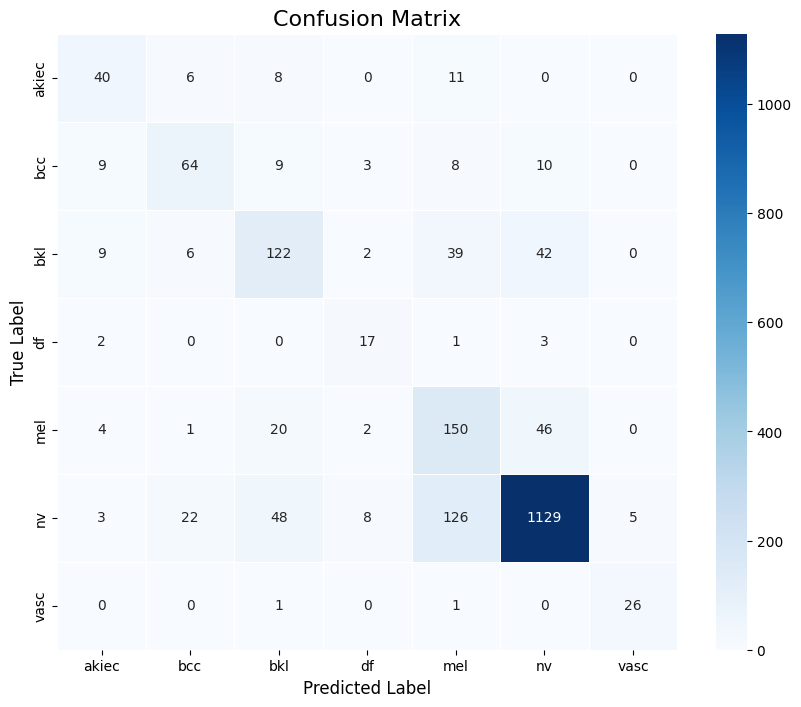

In [42]:
#################################
# Coded By: Cornelius Wong Qin Jun
#################################

print("--- Evaluating Final Model on the Unseen Test Set ---")
generate_evaluation_report(best_finetune_last3_inceptionv3_model, test_loader, DEVICE, label_names)